1. Installing Libraries

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import albumentations
from tqdm import trange, tqdm
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

2. Reading Dataset

In [2]:
train_data = pd.read_csv("../input/holiday-season/dataset/train.csv")
print(train_data.shape)
train_data.head()

(6469, 2)


,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [3]:
train_data.shape

(6469, 2)

In [4]:
#Encoding Output Variables
le = LabelEncoder()
train_data.Class = le.fit_transform(train_data.Class)
y_dict = dict(zip(range(len(le.classes_)),le.classes_))
y_dict

{0: 'Airplane',
 1: 'Candle',
 2: 'Christmas_Tree',
 3: 'Jacket',
 4: 'Miscellaneous',
 5: 'Snowman'}

In [5]:
train_data.head()

,Image,Class
0,image3476.jpg,4
1,image5198.jpg,1
2,image4183.jpg,5
3,image1806.jpg,4
4,image7831.jpg,4


In [6]:
train_data.Class.value_counts(normalize = True)

4    0.432988
2    0.237904
3    0.098933
1    0.091668
0    0.082702
5    0.055805
Name: Class, dtype: float64

In [7]:
#Splitting dataset into train and validation
df_train, df_val = train_test_split(
    train_data,
    test_size = 0.2,
    stratify = train_data['Class'],
    shuffle = True
)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_train.shape, df_val.shape

((5175, 2), (1294, 2))

In [8]:
#Loading Paths for Training and Validation Images
train_path = '../input/holiday-season/dataset/train'
train_image_paths = [
    os.path.join(train_path,i) for i in df_train.Image.values
]
val_image_paths = [
    os.path.join(train_path,i) for i in df_val.Image.values
]
train_image_paths[:5]

['../input/holiday-season/dataset/train/image1213.jpg',
 '../input/holiday-season/dataset/train/image2784.jpg',
 '../input/holiday-season/dataset/train/image2864.jpg',
 '../input/holiday-season/dataset/train/image6990.jpg',
 '../input/holiday-season/dataset/train/image1033.jpg']

In [9]:
#Loading Classes for images
train_targets = df_train.Class.values
val_targets = df_val.Class.values
train_targets

array([4, 4, 4, ..., 2, 3, 2])

3. Creating Dataset

In [10]:
class HolidayImageDataset:
    def __init__(self, 
                 image_paths,
                 targets,
                 augmentations = None
                ):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,item):
        targets = self.targets[item]
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.augmentations is not None:
                augmented = self.augmentations(image=image)
                image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32) 
        return {
            "image": torch.tensor(image),
            "targets": torch.tensor(targets),
        }

4. Creating Transformations for Training and Validation

In [11]:
train_aug = albumentations.Compose(
    [
        albumentations.RandomResizedCrop(64,64),
        albumentations.Transpose(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5)
    ]
)
val_aug = albumentations.Compose(
    [
        albumentations.Resize(64,64),
        albumentations.Transpose(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5)
    ]
)

In [12]:
#Creating train and validation set
train_dataset = HolidayImageDataset(
    train_image_paths,
    train_targets,
    augmentations = train_aug
)

val_dataset = HolidayImageDataset(
    val_image_paths,
    val_targets,
    augmentations = val_aug
)

BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
train_dataset[100]['image'].shape

torch.Size([3, 64, 64])

In [13]:
train_dataset[100]["targets"]

tensor(4)

In [14]:
#Plotting an image
def plot_img(image_dict):
    img_tensor = image_dict['image']
    target = image_dict['targets']
    print(target)
    plt.figure(figsize = (5,5))
    image = img_tensor.permute(1,2,0) / 255
    plt.imshow(image)

tensor(4)


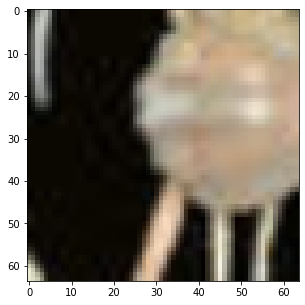

In [15]:
plot_img(train_dataset[1])

6. Creating Model Class

In [16]:
class HolidaySeasonModel(nn.Module):
    def __init__(self, num_classes,pretrained = True):
        super().__init__()
        self.convnet = torchvision.models.resnext50_32x4d(pretrained = pretrained)
        self.convnet.fc = nn.Linear(2048, num_classes)
        
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.CrossEntropyLoss()(outputs, targets)
    
    def fetch_optimizer(self):
        opt = Adam(self.parameters(), lr = 1e-3)
        return opt
    
    def train_one_epoch(self, data_loader):
        self.train()
        tk0 = tqdm(data_loader, total=len(data_loader))
        for b_idx, data in enumerate(tk0):
            loss, metrics = self.train_one_step(data)
            losses.update(loss.item(), data_loader.batch_size)
        return losses.avg
    
    def train_one_step(self, data):
        self.optimizer.zero_grad()
        _, loss, metrics = self.model_fn(data)
        
        with torch.set_grad_enabled(True):
            if self.fp16:
                with torch.cuda.amp.autocast():
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
            else:
                loss.backward()
                self.optimizer.step()
        if self.scheduler:
            if self.step_scheduler_after == "batch":
                if self.step_scheduler_metric is None:
                    self.scheduler.step()
                else:
                    step_metric = self.name_to_metric(self.step_scheduler_metric)
                    self.scheduler.step(step_metric)
        return loss, metrics

    
    def forward(self, image, targets = None):
        outputs = self.convnet(image)
        if targets is not None:
            loss = self.loss(outputs, targets)
            return outputs, loss
        return outputs, None
    
    def fit(self, 
            train_dataset,
            valid_dataset=None,
            device="cuda",
            epochs=10,
            train_bs=16,
            valid_bs=16,
            ):
        self.train_loader = DataLoader(
                train_dataset,
                batch_size=train_bs,
                shuffle=True,
            )
        if valid_dataset is not None:
            self.val_loader = DataLoader(
                    train_dataset,
                    batch_size=train_bs,
                    shuffle=True,
                )
        self.optimizer = self.fetch_optimizer()
        
        for _ in range(epochs):
            train_loss = self.train_one_epoch(self.train_loader)
            if self.valid_loader:
                valid_loss = self.validate_one_epoch(self.valid_loader)
            self.optimizer.step()
            if self._model_state.value == "end":
                break
            self.current_epoch += 1
        self.train_state = enums.TrainingState.TRAIN_END

In [17]:
model = HolidaySeasonModel(num_classes = train_data.Class.nunique(),pretrained = True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [18]:
optimizer = Adam(model.parameters(), lr = 1e-3)

Training the model

In [19]:
train_loss_list = []
val_loss_list = []
train_f1 = []
val_f1 = []
train_preds = []
val_preds = []
train_actuals = []
val_actuals = []
#Empty the GPU memory as it might be memory and CPU intensive while training
torch.cuda.empty_cache()
#Number of times the whole dataset will run through the network and model is fine-tuned
epochs = 20
#Iterate over number of epochs
model.cuda()

for i in range(epochs):
    #Switch model to train phase where it will update gradients
    model.train()
    #Initaite train and validation loss, number of rows passed and number of batches passed
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    val_loss = 0
    nb_val_examples, nb_val_steps = 0, 0
    #Iterate over batches within the same epoch
    for batch in train_dataloader:
        images, classes = batch['image'].to(device), batch['targets'].to(device)
        #Initiate gradients to 0 as they tend to add up
        optimizer.zero_grad()
        #Forward pass the input data
        outputs, loss = model(images, classes)
        #We will be using the Binary Cross entropy loss with added sigmoid function after that in BCEWithLogitsLoss
        loss.backward()
        #Update the weights with the calculated gradients
        optimizer.step()
        #Add the loss of the batch to the final loss, number of rows and batches
        tr_loss += loss.item()
        nb_tr_examples += len(batch['targets'])
        nb_tr_steps += 1
        #
        _, predicted = torch.max(outputs.cpu(),1)
        train_preds.extend(list(predicted.numpy()))
        train_actuals.extend(list(classes.cpu().numpy()))
    f1_score_train = f1_score(train_actuals, train_preds, average = 'weighted')
    train_loss_list.append(tr_loss/nb_tr_examples)
    #Print the current training loss 
    print("Epoch:{} Train Loss:{} F1-Score Train:{}".format(i,tr_loss/nb_tr_examples,f1_score_train))
    #Switch the model to evaluate stage at which the gradients wont be updated
    model.eval()
    #Iterate over the validation data
    for step, batch in enumerate(val_dataloader):
        #We dont want to update the gradients
        with torch.no_grad():
            images, classes = batch['image'].to(device), batch['targets'].to(device)

            #Forward pass the input data
            outputs, loss = model(images, classes)
            #We will be using the Binary Cross entropy loss with added sigmoid function after that in BCEWithLogitsLoss
            val_loss += loss.item()
            nb_val_examples += len(batch['targets'])
            nb_val_steps += 1
            _, predicted = torch.max(outputs.cpu(),1)
            val_preds.extend(list(predicted.numpy()))
            val_actuals.extend(list(classes.cpu().numpy()))
    f1_score_val = f1_score(val_actuals, val_preds, average = 'weighted')
    #Print the current validation loss
    val_loss_list.append(val_loss/nb_val_examples)
    print("Epoch:{} Valid Loss:{} F1-Score Val:{}".format(i,val_loss/nb_val_examples, f1_score_val))

Epoch:0 Train Loss:0.08874421892534708 F1-Score Train:0.4641398467470278
Epoch:0 Valid Loss:0.23962358630606342 F1-Score Val:0.497681992041484
Epoch:1 Train Loss:0.08263754201971966 F1-Score Train:0.469730745453362
Epoch:1 Valid Loss:0.0735054952099666 F1-Score Val:0.515258965794733
Epoch:2 Train Loss:0.07761429092158442 F1-Score Train:0.4809804729375677
Epoch:2 Valid Loss:0.06927789777655506 F1-Score Val:0.5321667421048807
Epoch:3 Train Loss:0.07747662643303618 F1-Score Train:0.4876202570033961
Epoch:3 Valid Loss:0.08141194539608138 F1-Score Val:0.5368554434085533
Epoch:4 Train Loss:0.07601859373746862 F1-Score Train:0.4920030334338451
Epoch:4 Valid Loss:0.07032626102659766 F1-Score Val:0.5401693833330432
Epoch:5 Train Loss:0.07462537275996185 F1-Score Train:0.4967061690364046
Epoch:5 Valid Loss:0.06750792895992166 F1-Score Val:0.5487037632381365
Epoch:6 Train Loss:0.07481295433597289 F1-Score Train:0.49991428711020836
Epoch:6 Valid Loss:0.07705055465101275 F1-Score Val:0.556785874586

In [20]:
print(classification_report(train_actuals, train_preds))

              precision    recall  f1-score   support

           0       0.49      0.18      0.26      8560
           1       0.63      0.50      0.56      9480
           2       0.69      0.66      0.68     24620
           3       0.49      0.22      0.31     10240
           4       0.56      0.80      0.66     44820
           5       0.42      0.06      0.10      5780

    accuracy                           0.59    103500
   macro avg       0.55      0.40      0.43    103500
weighted avg       0.58      0.59      0.56    103500



In [21]:
print(classification_report(val_actuals, val_preds))

              precision    recall  f1-score   support

           0       0.56      0.25      0.35      2140
           1       0.70      0.54      0.61      2380
           2       0.76      0.76      0.76      6160
           3       0.40      0.41      0.41      2560
           4       0.61      0.76      0.68     11200
           5       0.48      0.08      0.13      1440

    accuracy                           0.63     25880
   macro avg       0.59      0.47      0.49     25880
weighted avg       0.62      0.63      0.61     25880



In [22]:
PATH = './holiday_season.pth'
torch.save(model.state_dict(),PATH)

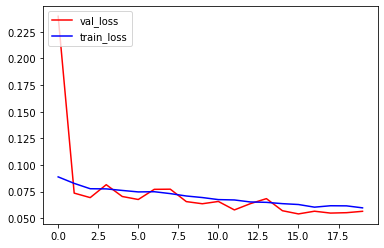

In [23]:
plt.plot(val_loss_list, '-r', label = 'val_loss')
plt.plot(train_loss_list, '-b', label='train_loss')
plt.legend(loc='upper left')

In [24]:
#Loading Paths for Test Images
import glob
test_path = '../input/holiday-season/dataset/test/*.jpg'
test_image_paths = glob.glob(test_path)
test_targets = [0 for _ in test_image_paths]
print(test_image_paths[:5])
test_aug = albumentations.Compose(
    [
        albumentations.Resize(64,64),
        albumentations.Transpose(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5)
    ]
)
test_dataset = HolidayImageDataset(
    test_image_paths,
    test_targets,
    augmentations = test_aug
)

BATCH_SIZE = 16
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

['../input/holiday-season/dataset/test/image7761.jpg', '../input/holiday-season/dataset/test/image3202.jpg', '../input/holiday-season/dataset/test/image688.jpg', '../input/holiday-season/dataset/test/image233.jpg', '../input/holiday-season/dataset/test/image4332.jpg']


In [25]:
predictions = []
#Iterate over the validation data
for step, batch in enumerate(test_dataloader):
    #We dont want to update the gradients
    with torch.no_grad():
        images, classes = batch['image'].to(device), batch['targets'].to(device)
        #Forward pass the input data
        outputs = model(images)
        _, predicted = torch.max(outputs[0].cpu(),1)
        predictions.extend(list(predicted.numpy()))

In [26]:
arr = os.listdir('../input/holiday-season/dataset/test/')
len(arr),len(predictions)

(3489, 3489)

In [27]:
submissions = pd.DataFrame(zip(arr,predictions), columns = ['Image','Class'])
submissions['Class'] = submissions['Class'].map(y_dict)
submissions.to_csv('submissions.csv', index = False)